## Imports and Data Loading

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [4]:
# load data
hr = pd.read_csv('data/alpaca_hr.csv')
resp = pd.read_csv('data/alpaca_resp.csv')
sao2 = pd.read_csv('data/alpaca_sao2.csv')

hr['offset'] = hr['offset'] / 60
resp['offset'] = resp['offset'] / 60
sao2['offset'] = sao2['offset'] / 60

gcs = pd.read_csv('data/patient_motor.csv')
gcs = gcs[gcs['observationoffset'] > -1]
gcs['observationoffset'] = gcs['observationoffset'] / 60


#display(hr)
#display(resp)
#display(sao2)

FileNotFoundError: [Errno 2] File b'data/patient_motor.csv' does not exist: b'data/patient_motor.csv'

In [53]:
# NOTE: Need to do this SEPARATELY for train/val/test
# deal with nan
interplim = 1000
hr = hr.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
resp = resp.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
sao2 = sao2.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))

#for now drop Nan rows (shouldn't be many)...
hr = hr.dropna()
resp = resp.dropna()
sao2 = sao2.dropna()
display(hr)

,patientunitstayid,offset,value
12,143274,1.016667,95.0
13,143274,1.100000,97.0
14,143274,1.183333,97.0
15,143274,1.266667,98.0
16,143274,1.350000,98.0
17,143274,1.433333,99.0
18,143274,1.516667,98.0
19,143274,1.600000,98.0
20,143274,1.683333,99.0
21,143274,1.766667,99.0


## Set Parameters

In [14]:
# prediction frequency refers to the frequency with which we want to predict GCS
prediction_freq = 2

# summarization interval refers to the spacing between edges of the bins of our histogram (for summarizing physiology)
summarization_int = 0.25

In [58]:
# split data into bins based on summarization_int
bins=np.arange(1000, step=summarization_int)
hr['offset_bin'] = pd.cut(hr['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
display(hr[hr['patientunitstayid'] == 318676])
hr_grouped = hr.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#hr_grouped['patientunitstayid'] = hr_grouped['patientunitstayid'].astype(int)

resp['offset_bin'] = pd.cut(resp['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
resp_grouped = resp.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#resp_grouped['patientunitstayid'] = resp_grouped['patientunitstayid'].astype(int)

sao2['offset_bin'] = pd.cut(sao2['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
sao2_grouped = sao2.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#sao2_grouped['patientunitstayid'] = sao2_grouped['patientunitstayid'].astype(int)

gcs['offset_bin'] = pd.cut(gcs['observationoffset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
gcs_grouped = gcs.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#gcs_grouped['patientunitstayid'] = gcs_grouped['patientunitstayid'].astype(int)

,patientunitstayid,offset,value,offset_bin
194191,318676,8.916667,98.0,35
194192,318676,9.000000,98.0,35
194193,318676,9.083333,101.0,36
194194,318676,9.166667,97.0,36
194195,318676,9.250000,96.0,36
194196,318676,9.333333,96.0,37
194197,318676,9.416667,94.0,37
194198,318676,9.500000,94.0,37
194199,318676,9.583333,93.0,38
194200,318676,9.666667,93.0,38


Text(0.5, 1.0, 'Motor GCS')

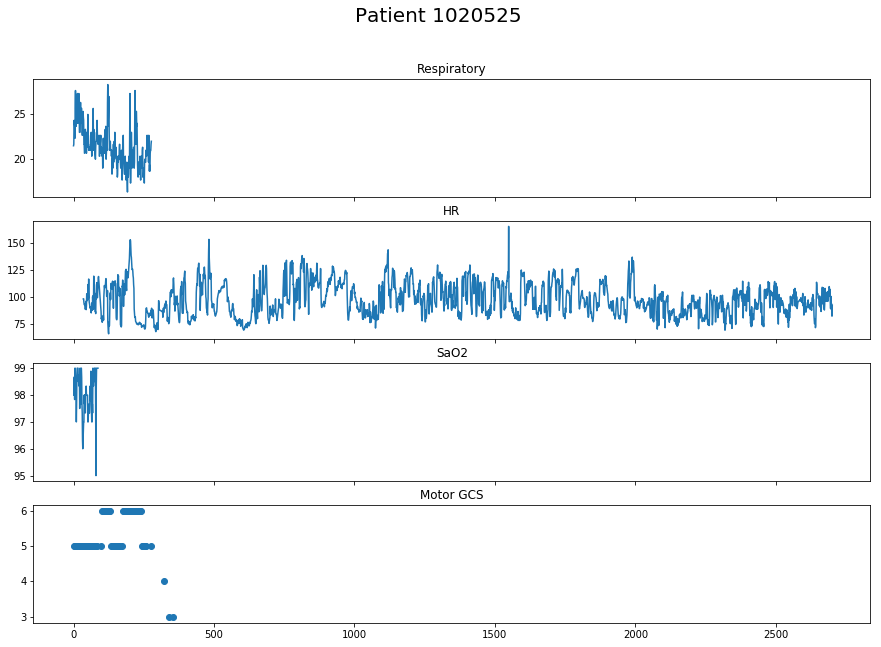

In [59]:
# get one patient's data
ind_slice = np.argwhere(hr_grouped['patientunitstayid'] == 318676).flatten()
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,10))
f.suptitle("Patient 1020525", size = 20)
ax1.plot(np.arange(resp_grouped[resp_grouped.index.isin(ind_slice)]['value'].shape[0]),
         resp_grouped[resp_grouped.index.isin(ind_slice)]['value'])
ax1.set_title("Respiratory")

ax2.plot(np.arange(hr_grouped[hr_grouped.index.isin(ind_slice)]['value'].shape[0]),
         hr_grouped[hr_grouped.index.isin(ind_slice)]['value'])
ax2.set_title("HR")

ax3.plot(np.arange(sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'].shape[0]),
         sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'])
ax3.set_title("SaO2")

ax4.scatter(gcs_grouped[gcs_grouped.index.isin(ind_slice)]['offset_bin'], gcs_grouped[gcs_grouped.index.isin(ind_slice)]['Value'])
ax4.set_title("Motor GCS")